# RNN on a Time Series
For these examples we're using data from the Federal Reserve Economic Database (FRED) concerning Sales of Beer, Wine, and Distilled Alcoholic Beverages in millions of dollars from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/S4248SM144NCEN

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load the dataset
We'll take advantage of pandas' built-in <a href='https://pandas.pydata.org/pandas-docs/stable/timeseries.html'>DatetimeIndex</a> by passing <tt>parse_dates=True</tt>

In [2]:
df = pd.read_csv('../Data/Alchohol_Sales.csv',index_col=0,parse_dates=True)
len(df)

340

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df.tail()

,S4248SM144NCEN
DATE,
2019-12-01,16197
2020-01-01,10659
2020-02-01,11350
2020-03-01,13410
2020-04-01,12378


In [5]:
df = df.iloc[:-3]
df.tail()

,S4248SM144NCEN
DATE,
2019-09-01,12992
2019-10-01,14427
2019-11-01,13773
2019-12-01,16197
2020-01-01,10659


In [6]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

In [7]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01'],
              dtype='datetime64[ns]', name='DATE', length=337, freq=None)

In [8]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

337

## Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>
Alternatively you could set your own limits with <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01-01'))</tt> or some other values.

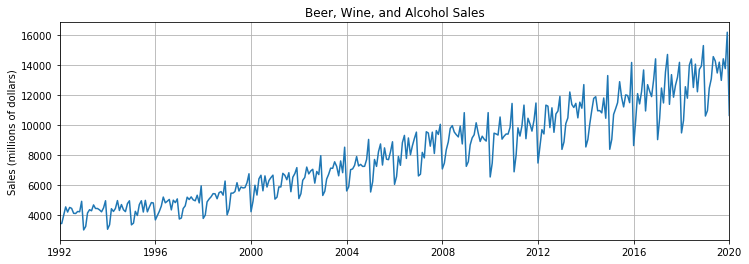

In [9]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

#### Plot first year sales

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01', '1992-11-01', '1992-12-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)


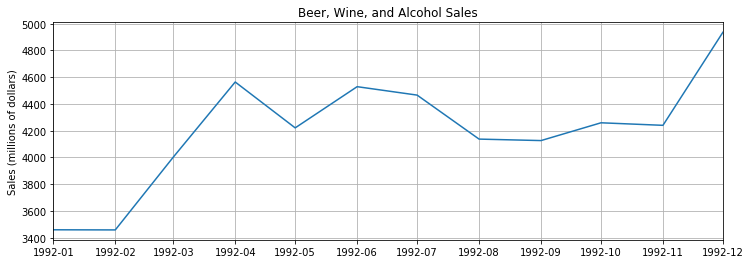

In [10]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
x = df.index[:12]
print(x)
plt.plot(x, df['S4248SM144NCEN'][:12])
plt.show()

## Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [11]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

The reason, we are working with df and not tensors yet is because the Sales values needs to be normalized <br>
Normalizing the data helps the model be able to update its weight and biases better<br>
Also note that there are some sharp increase and decrease in sales data <br>
Usually tensor's transform method has normalized built it, but since we working with df and numpy, we'll do it manually

## Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>
Recall that back in the CNN section we transformed image files using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt><strong>torchvision.transforms.Normalize(<em>mean, std</em>)</strong></tt></a>, both because it was built into DataLoader, and because our pretrained models expected specific normalization values.<br>

Ultimately we want to perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTE: We only want to normalize the training set to avoid data leakage. If we include the test set then the higher average values of the test set could become part of the signal in the training set. There's a good article on data leakage <a href='test_set = input_data(test_norm,window_size)'>here</a>.

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted values so that we can compare them to the actual test data.

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [13]:
# Normalize the training set
# Need to apply reshape or else transform will throw error
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

## Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become (325 - test_size).<br>
training set size = 340-12 = 328 <br>
Window size will be 12 to capture the seasonal trend of 12 months ~ 1 year<br>
Also we have to account for the window size, so final training data size = 328-12 = 314

In [14]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)
len(train_norm)

325

In [15]:
# Define a window size
window_size = 12

In [16]:
# Define function to create seq/next_data tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws] # 12 elements
        label = seq[i+ws:i+ws+1] # next value: value of 13th element
        out.append((window,label))
    return out

In [17]:
# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

313

In [18]:
train_data[0]

(tensor([-0.9303, -0.9304, -0.8418, -0.7503, -0.8061, -0.7560, -0.7662, -0.8198,
         -0.8216, -0.8000, -0.8030, -0.6897]),
 tensor([-1.]))

## Define the model
This time we'll use an LSTM layer of size (1,100).

In [19]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        
        # seq.view(len(seq), 1, -1) is the input
        # It's an array of 12 items since window size is 12
        # The .view is to reshape the input so it lines up correctly going into the LSTM model
        # self.hidden is the tuple (h_0, c_0)
        # lstm_out is the output that'll be fed to the linear layer
        # self.hidden is an updated tuple holding (h_n, c_n) where h_n, c_n are calculated values. Check notebook 81 for formula
        
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        
        # Here just feed the lstm_out (array of size 100) to get prediction for the prediction
        # pred will be a tensor of size 12
        # Reshape lstm_out before passing to linear layer 
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only care about the last prediction, which is the 13th value for the previous 12 data

## Instantiate the model, define loss and optimization functions

In [20]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [21]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


## Train the model

In [22]:
epochs = 150

import time
start_time = time.time()

for epoch in range(epochs):
    

    # tuple-unpack the train_data set
    # Seq is 12 y-values from train_data
    # y_train is the 13th value
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.26216507
Epoch:  2 Loss: 0.30497852
Epoch:  3 Loss: 0.17262718
Epoch:  4 Loss: 0.19480330
Epoch:  5 Loss: 0.19086072
Epoch:  6 Loss: 0.18267974
Epoch:  7 Loss: 0.18421011
Epoch:  8 Loss: 0.18229756
Epoch:  9 Loss: 0.16082476
Epoch: 10 Loss: 0.15770389
Epoch: 11 Loss: 0.15612866
Epoch: 12 Loss: 0.14924869
Epoch: 13 Loss: 0.14951490
Epoch: 14 Loss: 0.16373222
Epoch: 15 Loss: 0.16589515
Epoch: 16 Loss: 0.16472740
Epoch: 17 Loss: 0.17190520
Epoch: 18 Loss: 0.17004232
Epoch: 19 Loss: 0.17079541
Epoch: 20 Loss: 0.16999656
Epoch: 21 Loss: 0.16635990
Epoch: 22 Loss: 0.16450453
Epoch: 23 Loss: 0.16466707
Epoch: 24 Loss: 0.15625441
Epoch: 25 Loss: 0.15242907
Epoch: 26 Loss: 0.15021059
Epoch: 27 Loss: 0.14157254
Epoch: 28 Loss: 0.13219862
Epoch: 29 Loss: 0.11113893
Epoch: 30 Loss: 0.10326617
Epoch: 31 Loss: 0.07737455
Epoch: 32 Loss: 0.03855282
Epoch: 33 Loss: 0.00333534
Epoch: 34 Loss: 0.08811134
Epoch: 35 Loss: 0.06191740
Epoch: 36 Loss: 0.08497401
Epoch: 37 Loss: 0.03366999
E

<b>Note:</b> the loss values are really small because these are losses on the normalized data

## Run predictions and compare to known test set

In [23]:
future = 12

# Add the last window of training values to the list of predictions
# From there we predict the 13th value so let's say
# last window of training set: [100-112], predict 113th value
# next window: [101-113], predict 114th value and so on....

preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [24]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.2029547542333603,
 0.5343822836875916,
 0.44669774174690247,
 0.8727658987045288,
 0.9349254965782166,
 0.7409918308258057,
 1.0095971822738647,
 0.475128173828125,
 0.9629335403442383,
 0.879854142665863,
 1.3192784786224365,
 0.5002978444099426]

## Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [25]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10415.33775886],
       [12449.80564842],
       [11911.55408771],
       [14526.9734692 ],
       [14908.54016075],
       [13718.07835352],
       [15366.91230339],
       [12086.07429504],
       [15080.4675374 ],
       [14570.48465475],
       [17267.89094102],
       [12240.57831791]])

In [26]:
df['S4248SM144NCEN'][-12:]

DATE
2019-02-01    10976
2019-03-01    12472
2019-04-01    13098
2019-05-01    14573
2019-06-01    14277
2019-07-01    13484
2019-08-01    14205
2019-09-01    12992
2019-10-01    14427
2019-11-01    13773
2019-12-01    16197
2020-01-01    10659
Name: S4248SM144NCEN, dtype: int64

It looks like our predictions weren't that far off!
## Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [27]:
df.tail(12)

,S4248SM144NCEN
DATE,
2019-02-01,10976
2019-03-01,12472
2019-04-01,13098
2019-05-01,14573
2019-06-01,14277
2019-07-01,13484
2019-08-01,14205
2019-09-01,12992
2019-10-01,14427


In [28]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2020-02-01', '2021-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
       '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
       '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
      dtype='datetime64[D]')

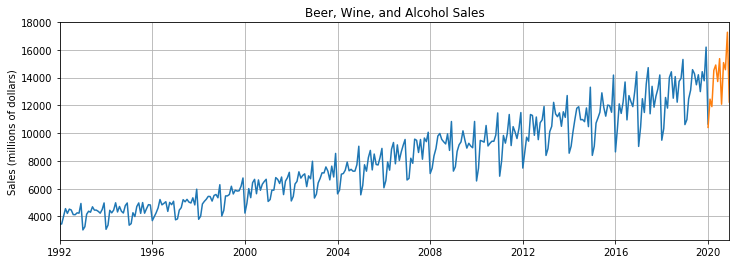

In [29]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

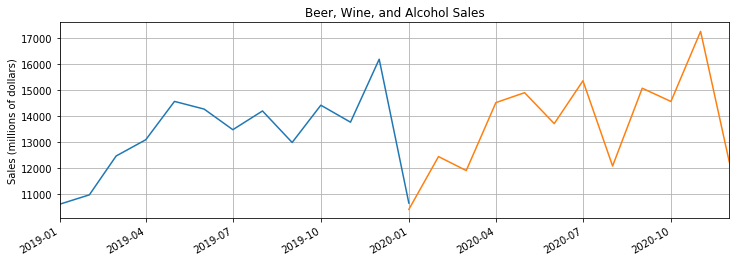

In [30]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2019-01-01':])
plt.plot(x,true_predictions)
plt.show()

# Forecast into an unknown future
This time we'll continue training the model using the entire dataset, and predict 12 steps into the future.

In [42]:
epochs = 155

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00002385
Epoch:  2 Loss: 0.00065042
Epoch:  3 Loss: 0.00000804
Epoch:  4 Loss: 0.00006065
Epoch:  5 Loss: 0.00166934
Epoch:  6 Loss: 0.00037333
Epoch:  7 Loss: 0.00008039
Epoch:  8 Loss: 0.00027499
Epoch:  9 Loss: 0.00003101
Epoch: 10 Loss: 0.00100877
Epoch: 11 Loss: 0.00092236
Epoch: 12 Loss: 0.00446310
Epoch: 13 Loss: 0.00015169
Epoch: 14 Loss: 0.00043962
Epoch: 15 Loss: 0.00082227
Epoch: 16 Loss: 0.00010310
Epoch: 17 Loss: 0.00000342
Epoch: 18 Loss: 0.00040761
Epoch: 19 Loss: 0.00119893
Epoch: 20 Loss: 0.00001626
Epoch: 21 Loss: 0.00033486
Epoch: 22 Loss: 0.00148626
Epoch: 23 Loss: 0.00002562
Epoch: 24 Loss: 0.00000207
Epoch: 25 Loss: 0.00007214
Epoch: 26 Loss: 0.00032291
Epoch: 27 Loss: 0.00003503
Epoch: 28 Loss: 0.00001993
Epoch: 29 Loss: 0.00008027
Epoch: 30 Loss: 0.00009025
Epoch: 31 Loss: 0.00006597
Epoch: 32 Loss: 0.00011326
Epoch: 33 Loss: 0.00041904
Epoch: 34 Loss: 0.00078979
Epoch: 35 Loss: 0.00038583
Epoch: 36 Loss: 0.00142965
Epoch: 37 Loss: 0.00004270
E

## Predict future values, plot the result

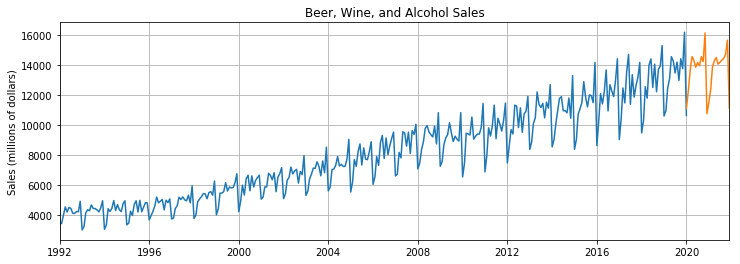

In [43]:
window_size = 12
future = 24
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2020-01-01', '2022-01-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()


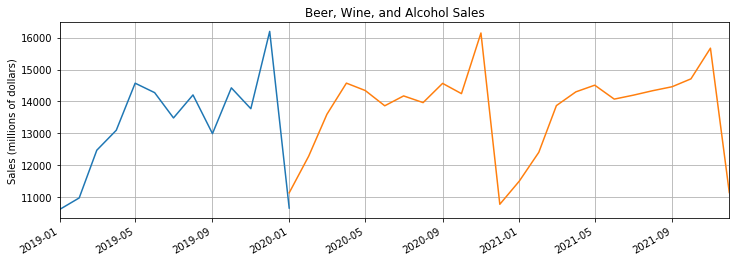

In [44]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2019-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

### Takeway:
- If the forecast doesn't seem accurate, check the loss
- If the loss is over 0.010, then repeat for greater epochs